<a href="https://colab.research.google.com/github/lucacerab/DSEthesis-transformers/blob/main/BERT1/UKP_7vs1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT UKP Sentential Argument Mining Corpus 7vs1 evaluation

Train on 7 topics test on the 8th for all the eight topics in the UKP dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%capture
!pip install transformers
from transformers import BertTokenizer
from transformers import TFAutoModel
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels

In [ ]:
train_df = pd.read_csv('/content/trainwithtopic.csv')
val_df = pd.read_csv('/content/valwithtopic.csv')
test_df = pd.read_csv('/content/testwithtopic.csv')

In [ ]:
print('train shape:', train_df.shape)
print('val shape:', val_df.shape)
print('test shape:', test_df.shape)

train shape: (18341, 3)
val shape: (2042, 3)
test shape: (5109, 3)


In [ ]:
train_df.head()

,topic,sentence,label
0,death penalty,Opponents of retribution theory believe in the...,2
1,death penalty,"In 1976 , the Supreme Court moved away from ab...",1
2,death penalty,"ProCon.org has more than 20,000,000 annual rea...",0
3,death penalty,"Therefore , whatever legitimacy is to be found...",2
4,death penalty,TW was in fact convicted of 1st degree murder ...,0


In [ ]:
#shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_df.head()

,topic,sentence,label
0,death penalty,One of the last ones occurred in 1936 in Kentu...,0
1,abortion,I personally feel very strongly about drunk dr...,0
2,minimum wage,It is therefore better to let the market take ...,2
3,nuclear energy,I still suspect that there is a range of stres...,0
4,marijuana legalization,"Stewart , who is 72 years old , gave an interv...",0


In [ ]:
print('train labels:', train_df.label.nunique())
print('val labels:', val_df.label.nunique())
print('test labels:', test_df.label.nunique())
print()
print('labels:', train_df.label.unique())

train labels: 3
val labels: 3
test labels: 3

labels: [0 2 1]


In [ ]:
train_df.label.value_counts()

0    10350
2     4447
1     3544
Name: label, dtype: int64

In [ ]:
#adapt dataset to binary classification: Arg_for (1) & Arg_against (2) = Argument (1)
train_df.loc[train_df['label'] == 2, 'label'] = 1
val_df.loc[val_df['label'] == 2, 'label'] = 1
test_df.loc[test_df['label'] == 2, 'label'] = 1

In [ ]:
print('train labels:', train_df.label.nunique())
print('val labels:', val_df.label.nunique())
print('test labels:', test_df.label.nunique())
print()
print('labels:', train_df.label.unique())

train labels: 2
val labels: 2
test labels: 2

labels: [0 1]


In [ ]:
train_df.label.value_counts()

0    10350
1     7991
Name: label, dtype: int64

In [ ]:
print(train_df.isna().sum())
print()
print(val_df.isna().sum())
print()
print(test_df.isna().sum())

topic       0
sentence    0
label       0
dtype: int64

topic       0
sentence    0
label       0
dtype: int64

topic       0
sentence    0
label       0
dtype: int64


In [ ]:
print(train_df.topic.nunique(), 'topics:', train_df.topic.unique())

8 topics: ['death penalty' 'abortion' 'minimum wage' 'nuclear energy'
 'marijuana legalization' 'gun control' 'school uniforms' 'cloning']


## Select test topic

In [ ]:
topic = 'nuclear energy'

In [ ]:
train_df = train_df[train_df['topic'] != topic].reset_index()
val_df = val_df[val_df['topic'] != topic].reset_index()
test_df = test_df[test_df['topic'] == topic].reset_index()

## Prepare data for BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [ ]:
#length of sentences
max_len = 64
def bert_encode(df, max_len):
  num_samples = len(df)

  X_ids = np.zeros((num_samples, max_len))
  X_mask = np.zeros((num_samples, max_len))
  X_type_ids = np.zeros((num_samples, max_len))
  

  for i, row in df.iterrows():
      encoded = tokenizer.encode_plus(row['topic'], row['sentence'], max_length=max_len,
                                      truncation=True, padding='max_length', add_special_tokens=True)    
      X_ids[i, :] = encoded['input_ids']
      X_mask[i, :] = encoded['attention_mask'] 
      X_type_ids[i, :] = encoded['token_type_ids'] 
  return X_ids, X_mask, X_type_ids

In [ ]:
train_input_ids, train_attention_masks, train_token_type_ids = bert_encode(train_df, max_len)
val_input_ids, val_attention_masks, val_token_type_ids = bert_encode(val_df, max_len)
test_input_ids, test_attention_masks, test_token_type_ids = bert_encode(test_df, max_len)

In [ ]:
train_token_type_ids[0]

array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
ex = train_input_ids[0]
ex

array([ 101., 1473., 6180.,  102., 1448., 1104., 1103., 1314., 3200.,
       3296., 1107., 3419., 1107., 4875.,  117., 1165., 1406.,  117.,
       1288., 1234., 5260., 1106., 2824., 1103., 5205., 1104.,  170.,
       1685., 2170., 1237., 2581.,  119.,  102.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.])

In [ ]:
tokenizer.decode(ex)

'[CLS] death penalty [SEP] One of the last ones occurred in 1936 in Kentucky, when 20, 000 people gathered to watch the hanging of a young African American male. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
print('topic:', train_df.topic[0])
print('sentence:', train_df.sentence[0])

topic: death penalty
sentence: One of the last ones occurred in 1936 in Kentucky , when 20,000 people gathered to watch the hanging of a young African American male .


In [ ]:
train_labels = train_df.label.values
val_labels = val_df.label.values
test_labels = test_df.label.values

## Train the model

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')
bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#define hyperparams
drop = 0.6

optimizer = Adam(learning_rate=2e-5)
loss = 'binary_crossentropy'
met = 'accuracy'

#freeze bert weigths
trainable = True

In [ ]:
def create_model(bert):
  input_ids = Input(shape=(max_len,), name="input_word_ids", dtype='int32')
  attention_masks = Input(shape=(max_len,), name="input_mask", dtype='int32')
  type_ids = Input(shape=(max_len,), name="segment_ids", dtype='int32')

  embeddings = bert.bert([input_ids, attention_masks, type_ids])[1]

  x = Dense(512, activation='relu')(embeddings)
  dropout = Dropout(drop, name='dropout')(x)
  output = Dense(1, activation='sigmoid', name='outputs')(dropout)
  
  model = Model(inputs = [input_ids, attention_masks, type_ids], outputs = output)

  model.layers[3].trainable = trainable

  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [ ]:
model = create_model(bert)
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 10

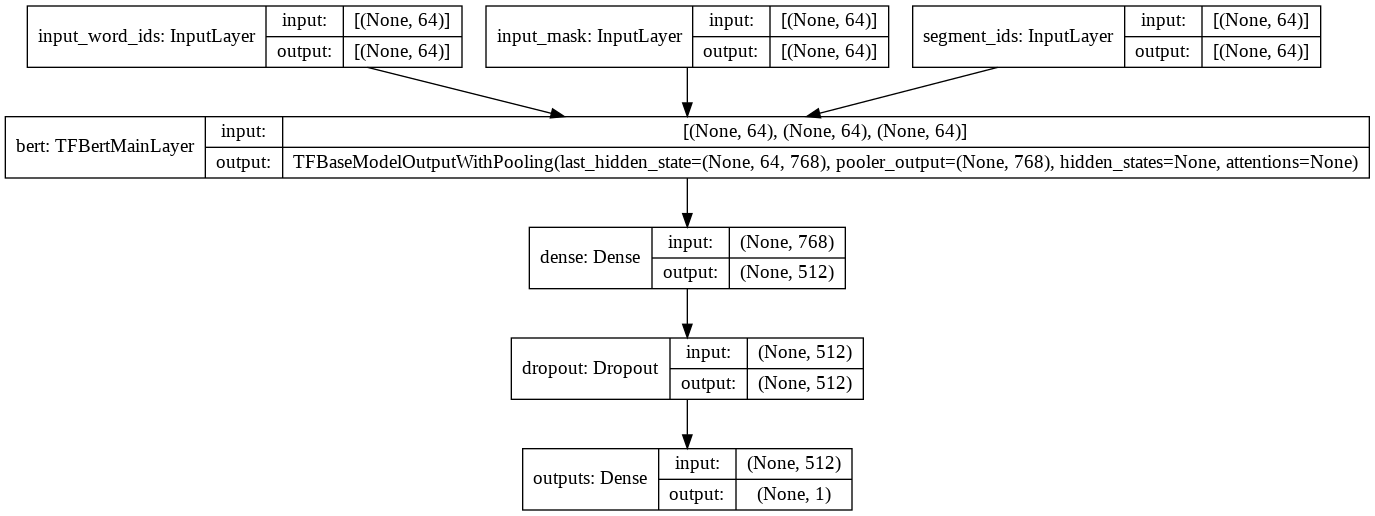

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 3
batch_size = 16

history = model.fit([train_input_ids, train_attention_masks, train_token_type_ids], train_labels,
                    validation_data=([val_input_ids, val_attention_masks, val_token_type_ids], val_labels),
                    epochs=epochs, batch_size=batch_size)

Epoch 1/3
986/986 [==============================] - 240s 229ms/step - loss: 0.4665 - accuracy: 0.7757 - val_loss: 0.3697 - val_accuracy: 0.8337
Epoch 2/3
986/986 [==============================] - 231s 234ms/step - loss: 0.3022 - accuracy: 0.8730 - val_loss: 0.4100 - val_accuracy: 0.8235
Epoch 3/3
986/986 [==============================] - 232s 235ms/step - loss: 0.1640 - accuracy: 0.9365 - val_loss: 0.5948 - val_accuracy: 0.8041


In [ ]:
result = model.predict([test_input_ids, test_attention_masks, test_token_type_ids])

In [ ]:
result = np.round(result).astype(int)

In [ ]:
test_df['preds'] = result
test_df.head()

,index,topic,sentence,label,preds
0,11,nuclear energy,Low levels of radiation comparable to those re...,1,1
1,18,nuclear energy,The U.S. Nuclear Regulatory Commission ( USNRC...,0,0
2,23,nuclear energy,CANE was a member of the Coalition for a Nucle...,0,0
3,30,nuclear energy,If we reduced safety standards to those applie...,1,1
4,67,nuclear energy,Chances are you are wearing cotton fibers righ...,0,0


## Evaluate performances

In [ ]:
#target_names = ['NoArg', 'Arg']
#print(classification_report(test_df.label, test_df.preds, target_names=target_names))

In [ ]:
# UKP eval function from https://github.com/UKPLab/acl2019-BERT-argument-classification-and-clustering/blob/master/argument-classification/ukp_evaluation.py

def analyze_predictions(dataset):
    total_sent = 0
    correct_sent = 0
    count = {}

    y_true = []
    y_pred = []

    for i,r in dataset.iterrows():
        gold = r['label']
        pred = r['preds']

        total_sent += 1
        if gold == pred:
            correct_sent += 1

        if gold not in count:
            count[gold] = {}

        if pred not in count[gold]:
            count[gold][pred] = 0

        count[gold][pred] += 1

        y_true.append(gold)
        y_pred.append(pred)

    print("gold - pred - Confusion Matrix")
    for gold_label in sorted(count.keys()):
        for pred_label in sorted(count[gold_label].keys()):
            print("%s - %s: %d" % (gold_label, pred_label, count[gold_label][pred_label]))


    print(":: BERT ::")
    print("Acc: %.2f%%" % (correct_sent/total_sent*100) )
    labels = unique_labels(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=None)
    rec = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    arg_f1 = []
    for idx, label in enumerate(labels):
        print("\n:: F1 for ", label, " ::")
        print("Prec: %.2f%%" % (prec[idx]*100))
        print("Recall: %.2f%%" % (rec[idx]*100))
        print("F1: %.2f%%" % (f1[idx]*100))

        if label in labels:
            if label != 'NoArgument':
                arg_f1.append(f1[idx])


    print("\n:: Macro Weighted for all  ::")
    print("F1: %.2f%%" % (np.mean(f1)*100))

    prec_mapping = {key:value for key, value in zip(labels, prec)}
    rec_mapping = {key:value for key, value in zip(labels, rec)}
    return np.mean(f1), prec_mapping, rec_mapping

In [ ]:
analyze_predictions(test_df)

gold - pred - Confusion Matrix
0 - 0: 231
0 - 1: 22
1 - 0: 71
1 - 1: 173
:: BERT ::
Acc: 81.29%

:: F1 for  0  ::
Prec: 76.49%
Recall: 91.30%
F1: 83.24%

:: F1 for  1  ::
Prec: 88.72%
Recall: 70.90%
F1: 78.82%

:: Macro Weighted for all  ::
F1: 81.03%


(0.8102936649633689,
 {0: 0.7649006622516556, 1: 0.8871794871794871},
 {0: 0.9130434782608695, 1: 0.7090163934426229})

In [ ]:
test_df.to_csv('UKP_nuclearenergy', index=False)